**This notebook builds the EfficientNet fracture prediction model with the integration of vertebrae classification output from teh EfficientNet vertebrae classification model.**

## Load Packages

In [1]:
import sys
sys.path.append('C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\kerasapplications')
sys.path.append('C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\efficientnet-keras-source-code\\')
import keras_applications
import efficientnet.tfkeras as efficientnet

C:\Users\public.DESKTOP-P7554KD\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2
import os
from os import listdir
import re
import gc

import gdcm
import pydicom as dicom
from pydicom import dcmread
import pylibjpeg
from pydicom.pixel_data_handlers.util import apply_voi_lut
from pydicom.data import get_testdata_files

from path import Path
import scipy.ndimage
from tqdm import tqdm
import nibabel as nib
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from glob import glob
import warnings
import dask.array as da

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator
from keras import layers

from PIL import Image as im
import traceback

import imageio


#from efficientnet_v2 import EfficientNetV2S
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.6)

### Data Loading


### Load the train images and train label

In [3]:

train_df = pd.read_csv("C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\train.csv")

train_dir = 'C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\train_images'


### Load vertebrae classification of the train images

In [85]:
vertebrae_infer = pd.read_csv('class_pred.csv')

vertebrae_infer

,patient_id,image_id,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,0.378213,0.271001,0.257165,0.321376,0.270718,0.369378,0.416669
1,1.2.826.0.1.3680043.10001,2,0.378213,0.271001,0.257165,0.321376,0.270718,0.369378,0.416669
2,1.2.826.0.1.3680043.10001,3,0.378213,0.271001,0.257165,0.321376,0.270718,0.369378,0.416669
3,1.2.826.0.1.3680043.10001,4,0.378213,0.271001,0.257165,0.321376,0.270718,0.369378,0.416669
4,1.2.826.0.1.3680043.10001,5,0.341577,0.186159,0.190069,0.276143,0.230544,0.325164,0.423477
...,...,...,...,...,...,...,...,...,...
106395,1.2.826.0.1.3680043.14669,263,0.204498,0.151299,0.131888,0.199384,0.195229,0.223207,0.441043
106396,1.2.826.0.1.3680043.14669,264,0.179163,0.154142,0.103150,0.200212,0.167246,0.198423,0.438631
106397,1.2.826.0.1.3680043.14669,265,0.179163,0.154142,0.103150,0.200212,0.167246,0.198423,0.438631
106398,1.2.826.0.1.3680043.14669,266,0.179163,0.154142,0.103150,0.200212,0.167246,0.198423,0.438631


### Classification based on prior analyzed classification threshold

In [86]:
vertebrae_infer.loc[vertebrae_infer['C1'] >=0.4, 'C1'] = 1
vertebrae_infer.loc[vertebrae_infer['C1'] < 0.4, 'C1'] = 0
vertebrae_infer.loc[vertebrae_infer['C2'] >=0.4, 'C2'] = 1
vertebrae_infer.loc[vertebrae_infer['C2'] < 0.4, 'C2'] = 0
vertebrae_infer.loc[vertebrae_infer['C3'] >=0.4, 'C3'] = 1
vertebrae_infer.loc[vertebrae_infer['C3'] < 0.4, 'C3'] = 0
vertebrae_infer.loc[vertebrae_infer['C4'] >=0.4, 'C4'] = 1
vertebrae_infer.loc[vertebrae_infer['C4'] < 0.4, 'C4'] = 0
vertebrae_infer.loc[vertebrae_infer['C5'] >=0.4, 'C5'] = 1
vertebrae_infer.loc[vertebrae_infer['C5'] < 0.4, 'C5'] = 0
vertebrae_infer.loc[vertebrae_infer['C6'] >=0.4, 'C6'] = 1
vertebrae_infer.loc[vertebrae_infer['C6'] < 0.4, 'C6'] = 0
vertebrae_infer.loc[vertebrae_infer['C7'] >=0.4, 'C7'] = 1
vertebrae_infer.loc[vertebrae_infer['C7'] < 0.4, 'C7'] = 0
vertebrae_infer

,patient_id,image_id,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.2.826.0.1.3680043.10001,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.2.826.0.1.3680043.10001,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.2.826.0.1.3680043.10001,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.2.826.0.1.3680043.10001,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
106395,1.2.826.0.1.3680043.14669,263,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106396,1.2.826.0.1.3680043.14669,264,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106397,1.2.826.0.1.3680043.14669,265,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106398,1.2.826.0.1.3680043.14669,266,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
train_df

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1
2016,1.2.826.0.1.3680043.14341,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.12053,0,0,0,0,0,0,0,0


### Prepare data to the fracture prediction model

In [87]:
vertebrae_infer_label = vertebrae_infer.merge(train_df, how='left',left_on = 'patient_id', right_on = 'StudyInstanceUID')
vertebrae_infer_label['C1'] =vertebrae_infer_label[['C1_x','C1_y']].min(axis=1)
vertebrae_infer_label['C2'] =vertebrae_infer_label[['C2_x','C2_y']].min(axis=1)
vertebrae_infer_label['C3'] =vertebrae_infer_label[['C3_x','C3_y']].min(axis=1)
vertebrae_infer_label['C4'] =vertebrae_infer_label[['C4_x','C4_y']].min(axis=1)
vertebrae_infer_label['C5'] =vertebrae_infer_label[['C5_x','C5_y']].min(axis=1)
vertebrae_infer_label['C6'] =vertebrae_infer_label[['C6_x','C6_y']].min(axis=1)
vertebrae_infer_label['C7'] =vertebrae_infer_label[['C7_x','C7_y']].min(axis=1)
vertebrae_infer_label['patient_overall'] =vertebrae_infer_label[['C1','C2','C3','C4','C5','C6','C7']].max(axis=1)

vertebrae_infer_label

,patient_id,image_id,C1_x,C2_x,C3_x,C4_x,C5_x,C6_x,C7_x,StudyInstanceUID,...,C5_y,C6_y,C7_y,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2.826.0.1.3680043.10001,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.2.826.0.1.3680043.10001,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2.826.0.1.3680043.10001,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.2.826.0.1.3680043.10001,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2.826.0.1.3680043.10001,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.2.826.0.1.3680043.10001,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2.826.0.1.3680043.10001,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.2.826.0.1.3680043.10001,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2.826.0.1.3680043.10001,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106395,1.2.826.0.1.3680043.14669,263,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2.826.0.1.3680043.14669,...,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106396,1.2.826.0.1.3680043.14669,264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2.826.0.1.3680043.14669,...,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106397,1.2.826.0.1.3680043.14669,265,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2.826.0.1.3680043.14669,...,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106398,1.2.826.0.1.3680043.14669,266,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2.826.0.1.3680043.14669,...,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [88]:
vertebrae_infer_label['C7'].sum()

12369.0

In [89]:
vertebrae_label=vertebrae_infer_label[['patient_id','image_id','C1','C2','C3','C4','C5','C6','C7','patient_overall']]
vertebrae_label

,patient_id,image_id,C1,C2,C3,C4,C5,C6,C7,patient_overall
0,1.2.826.0.1.3680043.10001,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.2.826.0.1.3680043.10001,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.2.826.0.1.3680043.10001,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.2.826.0.1.3680043.10001,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.2.826.0.1.3680043.10001,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
106395,1.2.826.0.1.3680043.14669,263,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
106396,1.2.826.0.1.3680043.14669,264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
106397,1.2.826.0.1.3680043.14669,265,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
106398,1.2.826.0.1.3680043.14669,266,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [90]:
vertebrae_label.loc[(vertebrae_label['patient_id']=='1.2.826.0.1.3680043.10001') & (vertebrae_label['image_id']==2),'C7']


1    0.0
Name: C7, dtype: float64

In [91]:
vertebrae_label.loc[(vertebrae_label['patient_id']=='1.2.826.0.1.3680043.10001') & (vertebrae_label['image_id']==100),'C7']

99    0.0
Name: C7, dtype: float64

In [92]:
idt = '1.2.826.0.1.3680043.10633'
            
            #need a step to skip ids that are outlier
            
path = os.path.join(train_dir, idt)
print(path)

        
#for i in range(len(os.listdir(path))):
print(os.listdir(path)[1].split('.')[0])
print(os.listdir(path)[2])

C:\Users\public.DESKTOP-P7554KD\Downloads\train_images\1.2.826.0.1.3680043.10633
10
100.dcm


## Utility Functions & Variables
### Load scans

In [93]:
#Loading Scans
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

# Load the scans in given folder path
def load_scan(path):
    
    dcm_paths = glob(f"{path}/*")
    dcm_paths.sort(key=natural_keys)
    
    patient_scan = [dicom.dcmread(paths) for paths in dcm_paths]
    
    return patient_scan

### HU Rescale

In [94]:
def get_pixels_hu(slices):
   
    image = np.stack([cv2.resize(s.pixel_array,(256,256),interpolation = cv2.INTER_NEAREST) for s in slices])
    #image = np.stack([cv2.cvtColor(s.pixel_array.reshape(512,512),cv2.COLOR_GRAY2RGB) for s in slices])

    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16) #int16
    image = da.from_array(image) #Using Dask to speed up processing
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
        
    intercept = da.from_array([slices[slice_number].RescaleIntercept for slice_number in range(len(slices))])
    slope = da.from_array([slices[slice_number].RescaleSlope for slice_number in range(len(slices))])
    
    intercept=intercept.reshape((-1,1,1))
    slope=slope.reshape((-1,1,1))
    #print(slope.shape)
    #print(image.shape)
    image= slope * image.astype("float64")
    #print(image.shape)   
    image+= intercept
    #print(image.shape)      
    return image.astype("int16")

### Normalization

In [95]:
MIN_BOUND = 150.0
MAX_BOUND = 2050.0
    
def normalize(image):
    image = (image - MIN_BOUND)*255.0 / (MAX_BOUND - MIN_BOUND)
    image[image>255] = 255.
    image[image<0] = 255.
    
    image = image.astype(np.int16)
    return image

In [ ]:
os.listdir(path)

## Train Generator 

Test on 1 patient

In [124]:
trainset = []
trainidt = []
trainlabel = []
        

idt = '1.2.826.0.1.3680043.10633'
            
            #need a step to skip ids that are outlier
            
path = os.path.join(train_dir, idt)
print(path)
patient_scan=load_scan(path)
patient_hu=get_pixels_hu(patient_scan)
patient_hu_normalised=normalize(patient_hu)
        
for i in range(len(os.listdir(path))):
    img = patient_hu_normalised[i]
    img = np.array(img)
    
    img = cv2.resize(img, (128 , 128))
    image = img_to_array(img)
    image = image / 255.0
    
    trainset += [image]
    cur_label = []
    cur_label.append(vertebrae_label.loc[(vertebrae_label['patient_id']==idt) & (vertebrae_label['image_id']==os.listdir(path)[i].split('.')[0]),'C7'])
    trainlabel += [cur_label]
    trainidt += [idt]
    


C:\Users\public.DESKTOP-P7554KD\Downloads\train_images\1.2.826.0.1.3680043.10633


Test on C7 vertebrae prediction

In [112]:
def RSNATrainGenerator(train_df, batch_size, infinite = True, base_path = train_dir):
    while True:
        trainset = []
        trainidt = []
        trainlabel = []
        for i in (range(len(train_df))):
            idt = train_df.loc[i, 'StudyInstanceUID']
            
            #need a step to skip ids that are outlier
            
            path = os.path.join(train_dir, idt)
            
            patient_scan=load_scan(path)
            patient_hu=get_pixels_hu(patient_scan)
            patient_hu_normalised=normalize(patient_hu)
            
            for j in range(len(os.listdir(path))):
                img = patient_hu_normalised[j]
                img = np.array(img)
                img = cv2.resize(img, (128 , 128))
                #img = cv2.resize(img, (224 , 224))
                image = img_to_array(img)
                image = image / 255.0
                trainset += [image]
                cur_label = []
                #cur_label.append(train_df.loc[i,'C1'])
                #cur_label.append(train_df.loc[i,'C2'])
                #cur_label.append(train_df.loc[i,'C3'])
                #cur_label.append(train_df.loc[i,'C4'])
                #cur_label.append(train_df.loc[i,'C5'])
                #cur_label.append(train_df.loc[i,'C6'])
                cur_label.append(vertebrae_label.loc[(vertebrae_label['patient_id']==idt) & (vertebrae_label['image_id']==os.listdir(path)[j].split('.')[0]),'C7'])
                #cur_label.append(train_df.loc[i,'patient_overall'])
                trainlabel += [cur_label]
                trainidt += [idt]
                if len(trainidt) == batch_size:                    
                    yield np.array(trainset), np.array(trainlabel)
                    trainset, trainlabel, trainidt = [], [], []
            i+=1

## Test Generator

In [113]:
def RSNATestGenerator(test_df, batch_size, infinite = True, base_path = train_dir):
    while 1:        
        testset=[]
        testidt=[]
        for i in (range(5)):        
            idt = test_df['StudyInstanceUID'].iloc[i]
            path = os.path.join(base_path, idt)
            
            patient_scan=load_scan(path)
            patient_hu=get_pixels_hu(patient_scan)
            patient_hu_normalised=normalize(patient_hu)
            
            if os.path.exists(path):
                 for j in range(len(os.listdir(path))):
                    img = patient_hu_normalised[j]
                    img = np.array(img)
                    img=cv2.resize(img,(128,128))
                    #img=cv2.resize(img,(224,224))
                    image=img_to_array(img)
                    image=image/255.0
                    testset+=[image]
                    testidt+=[idt]
                    if len(testset) == batch_size:                        
                        yield np.array(testset)
                        testset = []
        if len(testset) > 0: yield np.array(testset)
        if not infinite: break

## The Model

In [98]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [15]:
np.unique(train_df['C1'])

array([0, 1], dtype=int64)

In [99]:
from sklearn.utils import class_weight


class_weights_c1 = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(vertebrae_label['C1']), y = vertebrae_label['C1'])))
class_weights_c2 = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(vertebrae_label['C2']), y = vertebrae_label['C2'])))
class_weights_c3 = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(vertebrae_label['C3']), y = vertebrae_label['C3'])))
class_weights_c4 = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(vertebrae_label['C4']), y = vertebrae_label['C4'])))
class_weights_c5 = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(vertebrae_label['C5']), y = vertebrae_label['C5'])))
class_weights_c6 = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(vertebrae_label['C6']), y = vertebrae_label['C6'])))
class_weights_c7 = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(vertebrae_label['C7']), y = vertebrae_label['C7'])))
class_weights_overall = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(vertebrae_label['patient_overall']), 
                                                  y = train_df['patient_overall'])))

In [100]:
class_weights_c7

{0: 0.5657708628005658, 1: 4.301075268817204}

In [101]:
class_weights = np.array([class_weights_c1, class_weights_c2, class_weights_c3, class_weights_c4, class_weights_c5,
                         class_weights_c6, class_weights_c7, class_weights_overall])
class_weights

array([{0: 0.503768796636491, 1: 66.83417085427136},
       {0: 0.5020573024800876, 1: 122.01834862385321},
       {0: 0.5000187976991616, 1: 13300.0},
       {0: 0.5029306107014558, 1: 85.80645161290323},
       {0: 0.5044949360846641, 1: 56.118143459915615},
       {0: 0.5158087629315777, 1: 16.314014106102423},
       {0: 0.5657708628005658, 1: 4.301075268817204},
       {0: 0.9541587901701323, 1: 1.050468262226847}], dtype=object)

In [125]:
def get_model(metrics=METRICS, output_bias=None):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    inp = keras.layers.Input((None, None ,1))
    x = Conv2D(3, 3, padding = 'SAME')(inp)
    x = efficientnet.EfficientNetB5(include_top=False, weights='imagenet')(x)
    #x = efficientnet.EfficientNetB0(include_top=False, weights=None)(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    out = keras.layers.Dense(1, 'sigmoid', bias_initializer=None)(x) #8
    
    model = keras.models.Model(inp, out)
    
    model.summary()
    
    model.compile(loss="binary_crossentropy", 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005),#0.00005
                  metrics=metrics)
    return model

#### Main Training Cell

We use a stratified (based on patient_overall) KFold split and train 5 different models. 

In [126]:
i = 1
n = 2

for train_idx, val_idx in StratifiedKFold(n).split(train_df, train_df['patient_overall']):
    batch = 15 #150
    K.clear_session()
    x_train = train_df.iloc[train_idx].reset_index()
    x_val = train_df.iloc[val_idx].reset_index()
    model = get_model(output_bias=None)
    hist = model.fit(
        RSNATrainGenerator(x_train, min(len(x_train), batch),
                           infinite = False, 
                           base_path = train_dir),
        epochs = 15,
        verbose = 1,
        #class_weight=class_weights_c7,
        callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                   patience = 6, 
                                                   restore_best_weights = True)],
        validation_steps = max((len(x_val) // batch), 1),
        steps_per_epoch = max((len(x_train) // batch), 1),
       
        validation_data = RSNATrainGenerator(x_val, min(len(x_val), batch), 
                                             infinite = False, 
                                             base_path = train_dir)
    ) 
   
    model.save(f'effnet_whole_c7_ver{i}.h5')
    i= i+1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 3)     30        
                                                                 
 efficientnet-b5 (Functional  (None, None, None, 2048)  28513520 
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 28,515,599
Trainable params: 28,342,863
Non-tra

InvalidArgumentError: Graph execution error:

Can not squeeze dim[2], expected a dimension of 1, got 0
	 [[{{node remove_squeezable_dimensions/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_bool_Squeeze}}]] [Op:__inference_train_function_362520]

In [16]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    
    plt.figure(figsize=(12,12))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
            
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
            linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

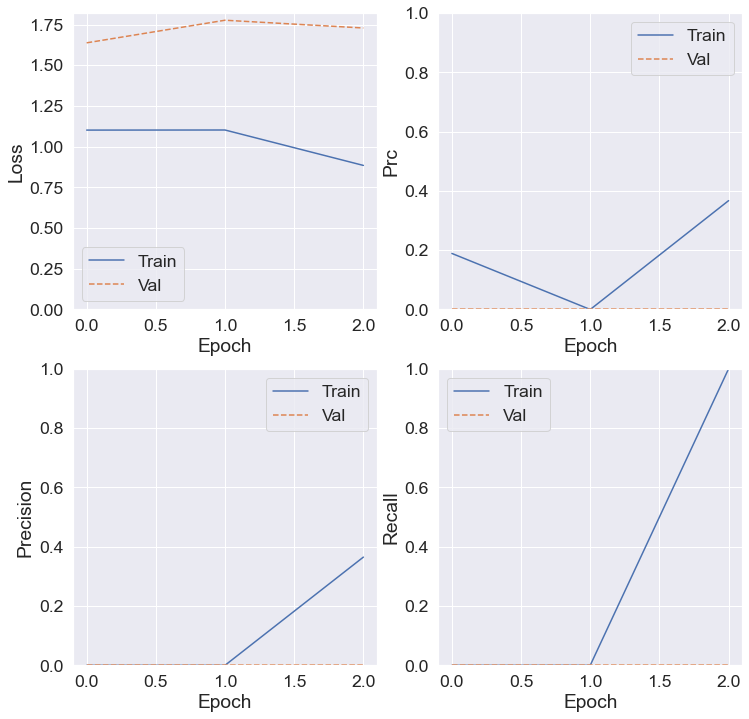

In [17]:
plot_metrics(hist)